In [11]:
import numpy as np
import pandas as pd
import os 

print('Data files:')
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print('   - ' + os.path.join(dirname, filename))

Data files:
   - data/test.csv
   - data/train.csv
   - data/sample_submission.csv


In [12]:
from transformers import TFBertModel, BertTokenizer
import matplotlib.pyplot as plt
import tensorflow as tf

## Setting the TPU
---

In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Downloading Data
---

In [14]:
train = pd.read_csv('data/train.csv')
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [15]:
def print_pair_and_label(index):
    print([train.premise.values[index], train.hypothesis.values[index], train.label.values[index]])
print_pair_and_label(3)

["you know they can't really defend themselves like somebody grown uh say my age you know yeah", "They can't defend themselves because of their age.", 0]


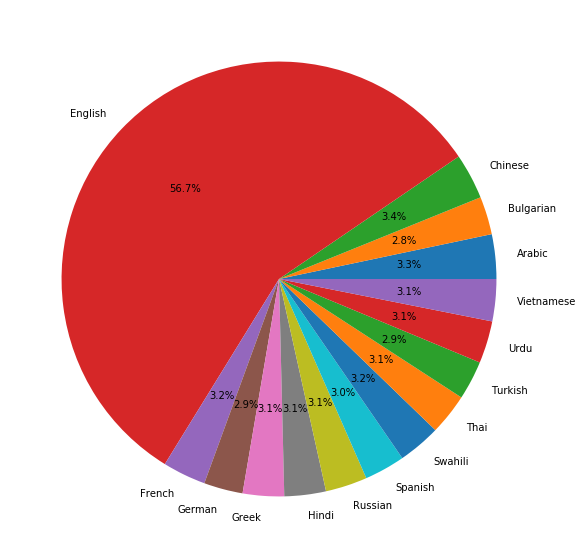

In [16]:
labels, frequences = np.unique(train.language.values, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(frequences, labels=labels, autopct='%1.1f%%');

## Prepare Data
---

In [17]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [18]:
def encode_sentence(str):
    tokens = list(tokenizer.tokenize(str))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

encode_sentence('I love you')

[146, 16138, 13028, 102]

In [19]:
def bert_encode(hypotheses, premises, tokenizer):
    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * num_examples
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask,
    'input_type_ids': input_type_ids}

    return inputs


In [20]:
train_input = bert_encode(train.hypothesis.values, train.premise.values, tokenizer)
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10117, 23123, ...,     0,     0,     0],
        [  101, 46184, 15647, ...,     0,     0,     0],
        [  101,   147,   112, ...,     0,     0,     0],
        ...,
        [  101, 10377, 25259, ...,     0,     0,     0],
        [  101, 10117, 13192, ...,     0,     0,     0],
        [  101, 68795, 15698, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

## Creating & Training Model
---

In [21]:
max_len = 259
from transformers import BertConfig

def build_model():
    config = BertConfig.from_pretrained(model_name)
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder(([input_word_ids, input_mask, input_type_ids]))[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
with strategy.scope():
    model = build_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)        

In [23]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [14]:
model.fit(train_input, train.label.values, epochs = 2, batch_size=64)

Epoch 1/2
  1/379 [..............................] - ETA: 23s - loss: 1.1634 - accuracy: 0.2812